## Imports

In [9]:
# General
import re
import string
import numpy as np
import pandas as pd
import warnings

# Visualization
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, WhitespaceTokenizer
from gensim.models import FastText

# Transformers
import torch
from transformers import AutoTokenizer, AutoModel, RobertaModel, RobertaTokenizer

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report,  f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Flatten, Dropout
from keras.utils import to_categorical


## Dataset



In [12]:
df = pd.read_csv('C:/Users/husse/Desktop/Emotional_Detection_3_Dec/Dataset/Emotional-Tone-Dataset.csv').head(8000)
df = df.drop('ID', axis=1)
df.columns = ['text', 'emotion']
df

,text,emotion
0,الاوليمبياد الجايه هكون لسه ف الكليه ..,none
1,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,anger
2,كتنا نيله ف حظنا الهباب xD,sadness
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,joy
4,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,none
...,...,...
7995,كره القدم في الاوليمبياد: بطوله بين مجموعه من ...,none
7996,: بوتين ينتقم من اطفال حلب путин мстит от д...,sadness
7997,one1: الخوف لا يمنع الموت ولكنه يمنع الحياه,fear
7998,StaracArabia واحلي تحيه لاولاد بلدي اجمد ناس ا...,joy


In [13]:
# rows_per_class = 1100

# result = df.groupby('emotion').head(rows_per_class)
# df = result.copy()
# df = df.reset_index(drop=True)

# df

## CLASS DISTRIBUTION

In [14]:
emotion_counts = df['emotion'].value_counts()
total_samples = len(df)

for emotion, count in emotion_counts.items():
    percentage = (count / total_samples) * 100
    print(f"{emotion}: Count = {count} -----------------> Percentage = {percentage:.2f}%")
print("df shape :",f"{df.shape}")
    
# have a balanced dataset with various emotions

none: Count = 1239 -----------------> Percentage = 15.49%
anger: Count = 1157 -----------------> Percentage = 14.46%
sadness: Count = 1021 -----------------> Percentage = 12.76%
joy: Count = 1010 -----------------> Percentage = 12.62%
love: Count = 974 -----------------> Percentage = 12.17%
fear: Count = 941 -----------------> Percentage = 11.76%
surprise: Count = 838 -----------------> Percentage = 10.47%
sympathy: Count = 820 -----------------> Percentage = 10.25%
df shape : (8000, 2)


In [15]:
df['emotion'].unique()

array(['none', 'anger', 'sadness', 'joy', 'surprise', 'love', 'sympathy',
       'fear'], dtype=object)

<Axes: title={'center': 'Count of each emotion'}>

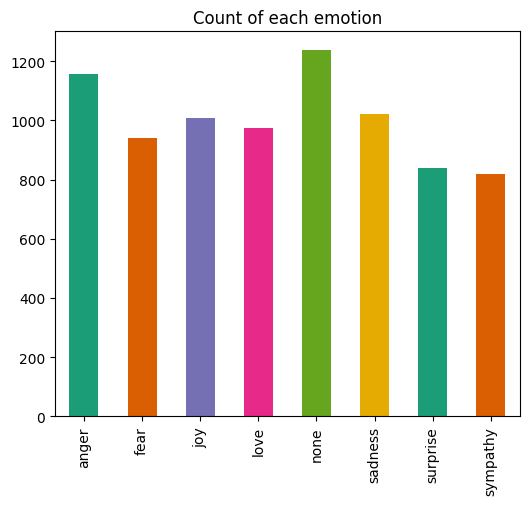

In [16]:
df['emotion'].value_counts().sort_index().plot(kind='bar', title='Count of each emotion', figsize=(6,5),color=sns.palettes.mpl_palette('Dark2'))

In [17]:
px.box(df, y=df["text"].astype(str).apply(lambda x: len(x.split())),
       color='emotion', template='plotly_white')


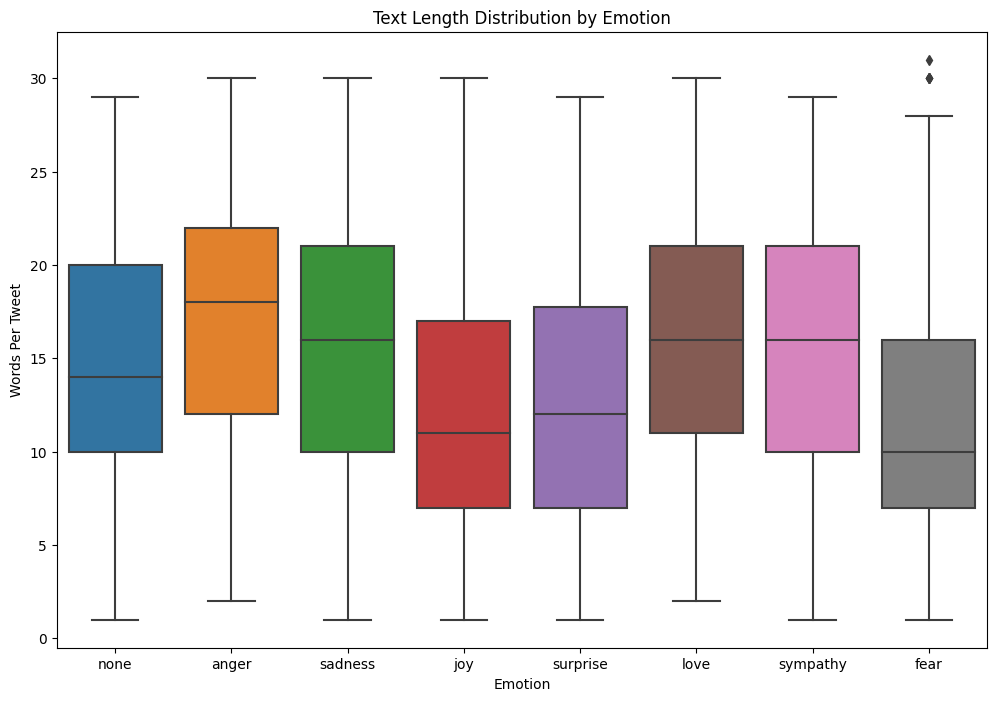

In [18]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='emotion', y=df['text'].apply(lambda x: len(x.split())), data=df)
plt.title('Text Length Distribution by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Words Per Tweet')
plt.show()

Your text cleaning function seems comprehensive for Arabic text. It handles the removal of non-Arabic Unicode characters, usernames, URLs, punctuation, escape codes, Arabic diacritization, and digits. Additionally, you tokenize the text and remove Arabic stopwords.

Applying this function to the 'text' column and creating a new 'cleanedText' column is a good practice for preparing the data for NLP tasks. It helps in removing noise and irrelevant information from the text.

In [19]:
# List of Arabic stopwords
arabic_stopwords = stopwords.words('arabic')

def clean_text(text):
    # Remove any non Arabic unicode
    text = re.sub(r'[^\u0600-\u06FF\s]+', ' ', text)
    # Remove username "@handle" from text
    text = re.sub(r'@\w+', '', text)
    # Remove URL from text
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation, emoji, and smileys from text
    text = re.sub(r'(?<=\w)[^\s\w](?![^\s\w])', '', text)
    # Remove escape codes like \n, \t, \, etc from text
    text = re.sub(r'(\n|\t|\"|\')', '', text)
    # Remove Arabic Diacritization (tashkeel) like fatha, damma, kasra, shaddah, ...
    text = re.sub(r'[\u064B-\u0652]', '', text)
    # Removing Digits
    text = re.sub(r'\d', '', text)

    # Tokenize the text
    words = word_tokenize(text)
    # Remove Arabic stopwords
    words = [word for word in words if word not in arabic_stopwords]

    return ' '.join(words)


# Apply the clean_and_tokenize function to the 'text' column
df['cleanedText'] = df['text'].apply(clean_text)
df

,text,emotion,cleanedText
0,الاوليمبياد الجايه هكون لسه ف الكليه ..,none,الاوليمبياد الجايه هكون لسه الكليه
1,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,anger,عجز الموازنه وصل الناتج المحلي يعني لسه اقل نف...
2,كتنا نيله ف حظنا الهباب xD,sadness,كتنا نيله حظنا الهباب
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,joy,جميعنا نريد تحقيق اهدافنا تونس تالقت حراسه المرمي
4,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,none,الاوليمبياد نظامها مختلف ومواعيد المونديال مكا...
...,...,...,...
7995,كره القدم في الاوليمبياد: بطوله بين مجموعه من ...,none,كره القدم الاوليمبياد بطوله مجموعه اللاعبين مش...
7996,: بوتين ينتقم من اطفال حلب путин мстит от д...,sadness,بوتين ينتقم اطفال حلب الاب حاملا جثه ابنته وال...
7997,one1: الخوف لا يمنع الموت ولكنه يمنع الحياه,fear,الخوف يمنع الموت ولكنه يمنع الحياه
7998,StaracArabia واحلي تحيه لاولاد بلدي اجمد ناس ا...,joy,واحلي تحيه لاولاد بلدي اجمد ناس المصريين وصحاب...


## Word Embedding
+ AraBert 

In [20]:
# Load AraBERT tokenizer and model
model_name = "aubmindlab/bert-base-arabertv02"
AraBERT_tokenizer = AutoTokenizer.from_pretrained(model_name)
AraBERT_model = AutoModel.from_pretrained(model_name)

In [21]:
def get_arabert_embedding(text):
    tokens = AraBERT_tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        model_output = AraBERT_model(**tokens)
    # Return the embeddings for the [CLS] token
    return model_output.last_hidden_state[:, 0, :].numpy()

In [22]:
# Apply the get_arabert_embedding function to the 'cleanedText' column
df['arabert_embedding'] = df['cleanedText'].apply(get_arabert_embedding)

loaded the AraBERT tokenizer and model and implemented a function to obtain embeddings for the 'cleanedText' column using the [CLS] token. Applying this function to create an 'arabert_embedding' column in your DataFrame is a good approach for obtaining contextual embeddings for Arabic text.

If you have specific questions or need further assistance, feel free to ask.

In [23]:
df  

,text,emotion,cleanedText,arabert_embedding
0,الاوليمبياد الجايه هكون لسه ف الكليه ..,none,الاوليمبياد الجايه هكون لسه الكليه,"[[0.32768285, -0.5181918, 0.06737751, -1.42059..."
1,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,anger,عجز الموازنه وصل الناتج المحلي يعني لسه اقل نف...,"[[-0.37491006, -1.5095029, -0.3598289, -0.8258..."
2,كتنا نيله ف حظنا الهباب xD,sadness,كتنا نيله حظنا الهباب,"[[0.20411977, 0.5643407, 0.08659431, -1.213814..."
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,joy,جميعنا نريد تحقيق اهدافنا تونس تالقت حراسه المرمي,"[[-0.06429669, -0.7303029, -0.13922364, -0.592..."
4,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,none,الاوليمبياد نظامها مختلف ومواعيد المونديال مكا...,"[[0.36728913, -1.1709914, -0.042227525, -0.112..."
...,...,...,...,...
7995,كره القدم في الاوليمبياد: بطوله بين مجموعه من ...,none,كره القدم الاوليمبياد بطوله مجموعه اللاعبين مش...,"[[-0.6733618, -1.3253055, 0.53130925, -0.21239..."
7996,: بوتين ينتقم من اطفال حلب путин мстит от д...,sadness,بوتين ينتقم اطفال حلب الاب حاملا جثه ابنته وال...,"[[0.32427046, -0.0801571, -0.5587897, -1.41472..."
7997,one1: الخوف لا يمنع الموت ولكنه يمنع الحياه,fear,الخوف يمنع الموت ولكنه يمنع الحياه,"[[0.60075366, -0.45551348, -0.28325605, -0.675..."
7998,StaracArabia واحلي تحيه لاولاد بلدي اجمد ناس ا...,joy,واحلي تحيه لاولاد بلدي اجمد ناس المصريين وصحاب...,"[[-0.7329391, -1.1172686, 0.21640114, -0.76743..."


## Model Devaloppement
+ Train Test Split
+ Bi-LSTM model
+ classification report

In [24]:
X = df['arabert_embedding'].to_numpy()
y = df['emotion']

# Use LabelEncoder to encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Pad sequences to have the same length
X_train_pad = pad_sequences(X_train, padding='post', dtype='float32')
X_test_pad = pad_sequences(X_test, padding='post', dtype='float32')

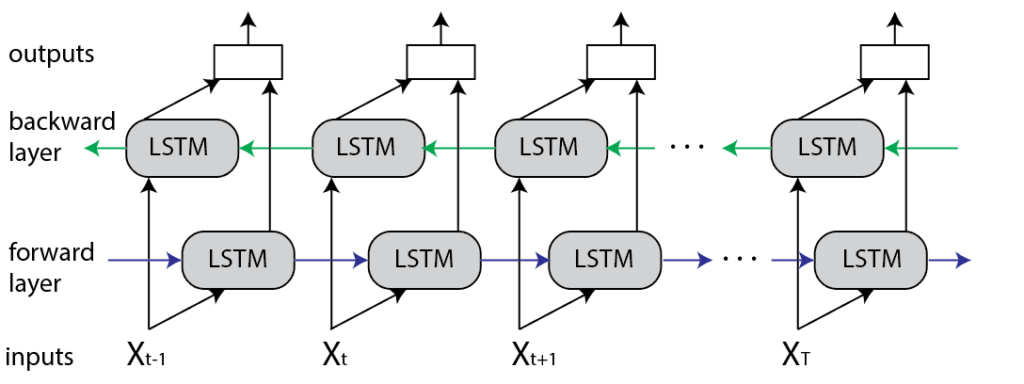

In [25]:
# # Bidirectional LSTM model
# lstm_model = Sequential()
# lstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_pad.shape[1], X_train_pad.shape[2])))
# lstm_model.add(Bidirectional(LSTM(32)))
# lstm_model.add(Dense(len(df['emotion'].unique()), activation='softmax'))

# # Compile the model
# lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# history = lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.2)

# # Evaluate the model
# y_pred_prob = lstm_model.predict(X_test_pad)
# y_pred = np.argmax(y_pred_prob, axis=1)

# # Get class names
# class_names = label_encoder.classes_

# # Print class names in the classification report
# report = classification_report(y_test, y_pred, target_names=class_names)
# accuracy = accuracy_score(y_test, y_pred)

# print(f"Accuracy: {accuracy:.2%}")



Epoch 1/5


140/140 [==============================] - 7s 16ms/step - loss: 1.3687 - accuracy: 0.5315 - val_loss: 1.1099 - val_accuracy: 0.6089
Epoch 2/5
140/140 [==============================] - 1s 6ms/step - loss: 1.0082 - accuracy: 0.6455 - val_loss: 1.0608 - val_accuracy: 0.6339
Epoch 3/5
140/140 [==============================] - 1s 6ms/step - loss: 0.8987 - accuracy: 0.6792 - val_loss: 1.0476 - val_accuracy: 0.6134
Epoch 4/5
140/140 [==============================] - 1s 6ms/step - loss: 0.8320 - accuracy: 0.7013 - val_loss: 1.0486 - val_accuracy: 0.6375
Epoch 5/5
75/75 [==============================] - 1s 2ms/step
Accuracy: 64.88%


In [35]:
from keras.layers import Input, Dense, Bidirectional, LSTM, Embedding, Attention, GlobalAveragePooling1D
from keras.models import Model

# Input layer
inputs = Input(shape=(X_train_pad.shape[1], X_train_pad.shape[2]))

# Bidirectional LSTM layer
lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(inputs)

# Transformer layer
transformer_layer = Attention()([lstm_layer, lstm_layer])  # You can adjust this according to your model architecture

# Global Average Pooling layer
avg_pooling = GlobalAveragePooling1D()(transformer_layer)

# Dense layer for classification
outputs = Dense(len(df['emotion'].unique()), activation='softmax')(avg_pooling)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get class names
class_names = label_encoder.classes_

# Print class names in the classification report
report = classification_report(y_test, y_pred, target_names=class_names)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2%}")
print("Classification Report:\n", report)


Epoch 1/5
140/140 [==============================] - 4s 10ms/step - loss: 1.2891 - accuracy: 0.5551 - val_loss: 1.1243 - val_accuracy: 0.5830
Epoch 2/5
140/140 [==============================] - 1s 5ms/step - loss: 0.9867 - accuracy: 0.6569 - val_loss: 1.0920 - val_accuracy: 0.6036
Epoch 3/5
140/140 [==============================] - 1s 5ms/step - loss: 0.8839 - accuracy: 0.6846 - val_loss: 1.0541 - val_accuracy: 0.6393
Epoch 4/5
140/140 [==============================] - 1s 5ms/step - loss: 0.8327 - accuracy: 0.7074 - val_loss: 1.0361 - val_accuracy: 0.6321
Epoch 5/5
75/75 [==============================] - 1s 2ms/step
Accuracy: 66.38%
Classification Report:
               precision    recall  f1-score   support

       anger       0.60      0.66      0.63       341
        fear       0.90      0.83      0.87       287
         joy       0.54      0.56      0.55       305
        love       0.81      0.63      0.71       317
        none       0.65      0.86      0.74       363
     s

In [36]:
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       anger       0.60      0.66      0.63       341
        fear       0.90      0.83      0.87       287
         joy       0.54      0.56      0.55       305
        love       0.81      0.63      0.71       317
        none       0.65      0.86      0.74       363
     sadness       0.51      0.50      0.50       290
    surprise       0.59      0.43      0.50       246
    sympathy       0.76      0.79      0.77       251

    accuracy                           0.66      2400
   macro avg       0.67      0.66      0.66      2400
weighted avg       0.67      0.66      0.66      2400



In [37]:
# lstm_model.save('emotion_detection_model.h5')

In [38]:
# import joblib
# joblib.dump(label_encoder, 'label_encoder.joblib')

In [39]:
# # Plot training loss
# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

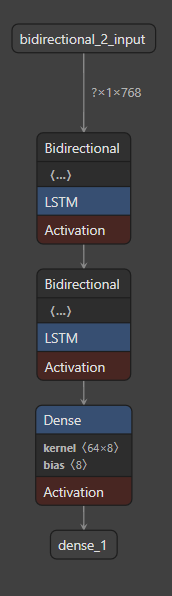

## Testing Models


In [40]:
def clean_text_Franco(text):
    # Remove URLs https://www.example.com/
    text = re.sub(r'http\S+', '', text)
    # Remove user mentions @mohamed_samy
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove hashtags #free_palestine
    text = re.sub(r'#', '', text)
    # Remove punctuation period, comma, apostrophe, quotation, question, exclamation, brackets, braces, parenthesis, dash, hyphen, ellipsis, colon, semicolon
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Convert to lower case
    tokens = [word.lower() for word in tokens]
    # Join the tokens back into a clean text
    clean_text = ' '.join(tokens)

    return clean_text

def is_arabic(text):
    arabic_letters = set("ابتثجحخدذرزسشصضطظعغفقكلمنهويءآأؤإئى")
    return any(char in arabic_letters for char in text)

from googletrans import Translator

def translate_to_arabic(text):
    translator = Translator()
    translation = translator.translate(text, dest='ar')
    return translation.text
def test_model_with_probabilities(model, label_encoder, text):

    if not is_arabic(text):
        print("Input is Franco-Arabic!")
        print("\n")

        print(f"Original User Input: {text}")
        print("\n")

        clean_Franco = clean_text_Franco(text)
        print(f"Cleaned User Input: {clean_Franco}")
        print("\n")

        translated_user_input = translate_to_arabic(clean_Franco)
        print(f"Translated User Input: {translated_user_input}")
        print("\n")


        text = translated_user_input
    else:
        print("Input is Arabic!")
        print("\n")

        print(f"Original User Input: {text}")
        print("\n")

        clean_user_input = clean_text(text)
        print(f"Cleaned User Input: {clean_user_input}")
        print("\n")
        
        text = clean_user_input

    print("----------------------------------------------------------------")

    embedding = get_arabert_embedding(text)
    # Pad the sequence
    padded_sequence = pad_sequences([embedding], padding='post', dtype='float32')
    # Make predictions
    prediction_prob = model.predict(padded_sequence)
    predicted_class = np.argmax(prediction_prob)
    # Convert predicted class back to the original label
    predicted_label = label_encoder.classes_[predicted_class]
    # Get class probabilities
    class_probabilities = {label: prob for label, prob in zip(label_encoder.classes_, prediction_prob[0])}

    return predicted_label, class_probabilities

In [41]:
# # Check if the text is Franco-Arabic and translate if needed
# for index, row in test_df.iterrows():
#     text = row['cleanedText']
#     translated_text = translate_to_arabic(text)
#     test_df.at[index, 'translatedText'] = translated_text
#     test_df.at[index, 'isTranslated'] = True

In [42]:
# # Load the Franco-Arabic test dataset
# test_df = pd.read_csv('Arabic_test.csv')

# test_df = test_df[test_df['emotion'] != 'none']

# # Apply the cleaning and translation to the test dataset
# test_df['cleanedText'] = test_df['text'].apply(clean_text_Franco)

# # trabslate the test dataset to arabic 
# test_df['arabic_text'] = test_df['cleanedText'].apply(translate_to_arabic)

# # Get AraBERT embeddings for the translated text
# test_df['arabert_embedding'] = test_df['arabic_text'].apply(get_arabert_embedding)

# # Pad sequences
# X_test_pad = pad_sequences(test_df['arabert_embedding'].to_numpy(), padding='post', dtype='float32')

# # Test the model
# y_pred_prob = lstm_model.predict(X_test_pad)
# y_pred = np.argmax(y_pred_prob, axis=1)

# # Inverse transform predictions to get emotion labels
# predicted_emotions = label_encoder.inverse_transform(y_pred)

# # Add predicted emotions to the test dataframe
# test_df['predicted_emotion'] = predicted_emotions

# # Display the test results
# print(test_df[['text', 'predicted_emotion']])
# print("Classification Report:")
# print(classification_report(test_df['emotion'], test_df['predicted_emotion']))

In [44]:
# test_df['emotion'].unique()

In [45]:
# test_df.shape

In [46]:
def analyze_user_input(user_input_text):
    predicted_emotion, class_probabilities = test_model_with_probabilities(lstm_model, label_encoder, user_input_text)

    # Calculate total probability
    total_probability = sum(class_probabilities.values())

    # Print predicted emotion and percentage of each class in descending order
    print(f"Predicted Emotion: {predicted_emotion}")
    print("----------------------------------------------------------------")
    print("Class Probabilities:")
    sorted_probabilities = dict(sorted(class_probabilities.items(), key=lambda item: item[1], reverse=True))
    for emotion, probability in sorted_probabilities.items():
        percentage = (probability / total_probability) * 100
        print(f"{emotion}: {percentage:.2f}%")
    print("----------------------------------------------------------------")

    # Plotting the results
    fig, ax = plt.subplots()
    ax.bar(sorted_probabilities.keys(), sorted_probabilities.values())
    ax.set_ylabel('Probability')
    ax.set_title(f'Emotion Prediction (Descending Order)')
    ax.tick_params(axis='x', rotation=45)

    plt.show()


Input is Franco-Arabic!


Original User Input: @user_name elmat3am kan 7elw awii😍!! w kona mabsooten gdan😊, shof elmakan hena ---> https://mat3am.com


Cleaned User Input: elmat3am kan 7elw awii w kona mabsooten gdan shof elmakan hena


Translated User Input: المطعم كان حلو أوي و كنا مبسوطين جدا شوف المكان هنا


----------------------------------------------------------------
1/1 [==============================] - 2s 2s/step
Predicted Emotion: joy
----------------------------------------------------------------
Class Probabilities:
joy: 77.75%
surprise: 14.76%
sadness: 3.57%
love: 1.09%
none: 0.86%
sympathy: 0.79%
fear: 0.72%
anger: 0.46%
----------------------------------------------------------------


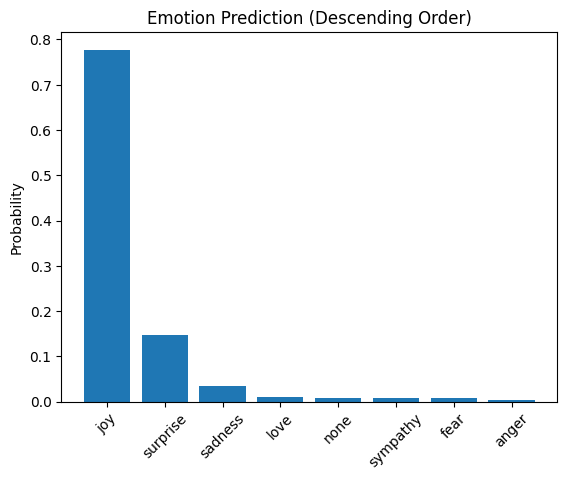

In [47]:
user_input_text = "@user_name elmat3am kan 7elw awii😍!! w kona mabsooten gdan😊, shof elmakan hena ---> https://mat3am.com"
analyze_user_input(user_input_text)

Input is Franco-Arabic!


Original User Input: eh elgaal da


Cleaned User Input: eh elgaal da


Translated User Input: إيه الجال دى


----------------------------------------------------------------
1/1 [==============================] - 0s 39ms/step
Predicted Emotion: surprise
----------------------------------------------------------------
Class Probabilities:
surprise: 88.04%
joy: 7.36%
anger: 1.88%
sadness: 1.20%
none: 1.11%
love: 0.18%
fear: 0.13%
sympathy: 0.09%
----------------------------------------------------------------


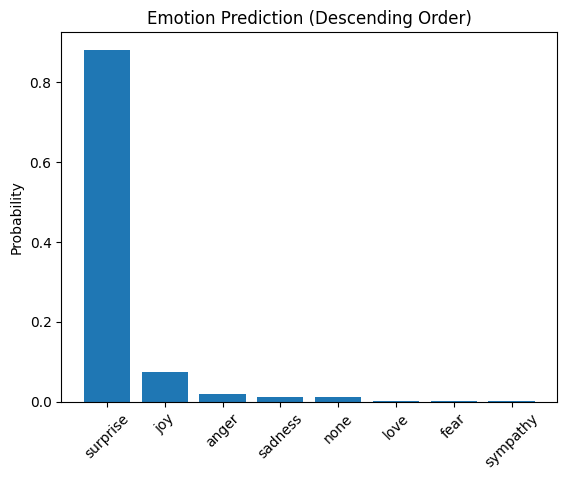

In [48]:
analyze_user_input(user_input_text = input("Enter your text: "))